# **Recommendation System**

Based on the customized convulation network model created, a recommendation system would be constructed around it by passing through images through the dataset trained by the deep learning model and closest matches being generated. The model of choice for matching would be based on the K-nearest neighbours algorithm. Random samples that represent each category will be tested and qualitatively analyzed for visual similarities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Import Libraries**

In [16]:
import numpy as np
import os
from os import listdir
import cv2
import random
from random import shuffle 
#from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils, to_categorical
import matplotlib.pyplot as plt

**Load Images from Directory**

In [3]:
#Unzip the data into the current working directory
!unzip -q "/content/drive/My Drive/Colab Notebooks/Shirt_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Footwear_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Watch_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Backpack_Images.zip"

In [4]:
#Move these folders into single folder names as Dataset
!mkdir Dataset
!mv Shirt_Images Dataset
!mv Footwear_Images Dataset
!mv Watch_Images Dataset
!mv Backpack_Images Dataset

In [5]:
ls Dataset/

Backpack_Images/  Footwear_Images/  Shirt_Images/  Watch_Images/


In [6]:
path = "Dataset/" 
image_size = 128
channels = 3
types = ["Shirt_Images","Footwear_Images","Watch_Images","Backpack_Images"]

total_images = 0
for root, dirs, files in os.walk(path):
    total_images += len(files)

#Initialize the containers for storing the image and labels
labels = np.empty(total_images)
images = np.empty((total_images,image_size,image_size,channels)) # Container for colored images
heights = np.empty(total_images)
widths = np.empty(total_images) 
count = 0

for i in types:
    print("Reading the  data for: ", i)
    for p in os.listdir(path + i):
        image = cv2.imread(path + i + '/' + p)
        heights[count] = image.shape[0]
        widths[count] = image.shape[1]
        image = cv2.resize(image, (image_size, image_size))
        image = image/255.0
        images[count] = image
        labels[count] = types.index(i)
        
        count+=1

print("\nNumber of Dataset {} and Number of Labels {}".format(len(images),len(np.unique(labels)))) 

Reading the  data for:  Shirt_Images
Reading the  data for:  Footwear_Images
Reading the  data for:  Watch_Images
Reading the  data for:  Backpack_Images

Number of Dataset 20000 and Number of Labels 4


**Splitting the Dataset for Training & Testing**

In [7]:
labels_categorical = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, shuffle=True, test_size=0.2, random_state=42)
print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("Y Train shape:", y_train.shape)
print("Y Test shape:", y_test.shape)

X Train shape: (16000, 128, 128, 3)
X Test shape: (4000, 128, 128, 3)
Y Train shape: (16000, 4)
Y Test shape: (4000, 4)


**CNN Feature Network**

In [8]:
# Create initial model
rec_model = Sequential()

rec_model.add(Conv2D(filters = 64,kernel_size = 3, activation='relu', input_shape=(128,128,3)))
rec_model.add(Dropout(rate = 0.1))
rec_model.add(MaxPooling2D(pool_size=(2,2)))

rec_model.add(Conv2D(filters= 128, kernel_size= 5,activation="relu"))
rec_model.add(Dropout(rate = 0.2))
rec_model.add(MaxPooling2D(pool_size=(2,2)))

rec_model.add(Flatten())

rec_model.add(Dense(1000, activation='relu'))
rec_model.add(Dropout(rate = 0.5))

rec_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 59, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 107648)           

**Implement K-Nearest Neighbors**

K-Nearest Neighbors will be used in the recommendation engine based on closest feature selection. Due to the number of classes being less than 5, K was set based on proximity of 4 closest matches. Euclidean distance would be used as the distance metric.

In [9]:
# Firstly, train the CNN features on the selected training set
features = rec_model.predict(X_train)
print(features.shape)

(16000, 1000)


In [25]:
# Secondly, build the KNN model and pass X-train dataset as input 
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric='euclidean', n_jobs = -1).fit(features)

In [29]:
# Select a random image from the X test set
random_index = np.random.randint(0,len(X_test)) 
single_image = X_test[random_index]

# Apply the learning network on chosen image
single_image_features = rec_model.predict(np.expand_dims(single_image,axis=0))
print(single_image_features.shape)

# Pass through the KNN model to fetch the 4 closest matches. 
# Finds the K-neighbors of a point and returns indices of and distances to the neighbors of each point.
indices = nbrs.kneighbors(single_image_features,4,return_distance=False)

(1, 1000)


In [21]:
print(indices.shape)

(1, 3)


In [22]:
print(indices)

[[4303 4816 5247]]


## **Test Recommendation Model**

**Test #1 Image Generation**

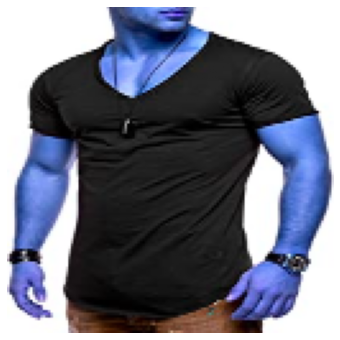

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(single_image)
plt.axis('off') 
plt.show()

**Test #1 Results - Closest Matching Images**

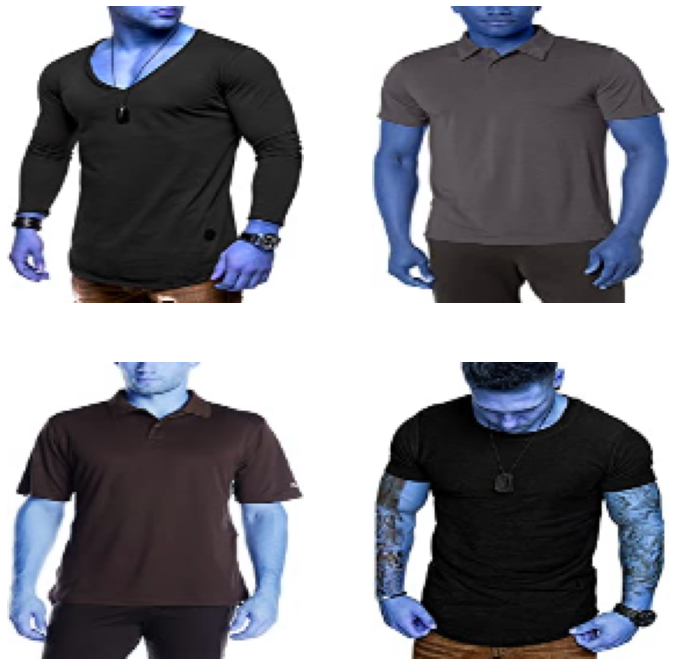

In [31]:
fig=plt.figure(figsize=(12, 12))
for i in range(1, 5):
    fig.add_subplot(2, 2, i)
    plt.imshow(X_train[indices[0,i-1]])
    plt.axis('off') 
plt.show()

We can observe that all images were classed correctly as shirts with the closest matching one being the same human model where a long-sleeved version. All return images had human figure as well with even matchng accessories for 2 of the images. Color wise, it also returns the same skin tone color which shows a good accuracy even for rgd detection.

**Test #2 Image Generation**

In [41]:
# Repeat KNN prediction on random image
random_index2 = np.random.randint(0,len(X_test)) 
single_image2 = X_test[random_index2]
single_image2_features = rec_model.predict(np.expand_dims(single_image2,axis=0))
indices2 = nbrs.kneighbors(single_image2_features,4,return_distance=False)

(1, 1000)


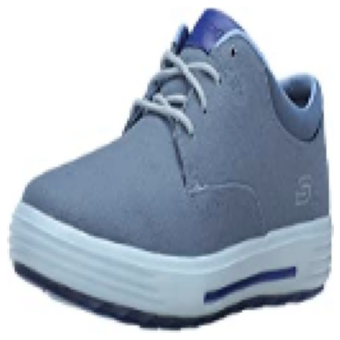

In [42]:
plt.figure(figsize=(6, 6))
plt.imshow(single_image2)
plt.axis('off') 
plt.show()

**Test #2 Results - Closest Matching Images**

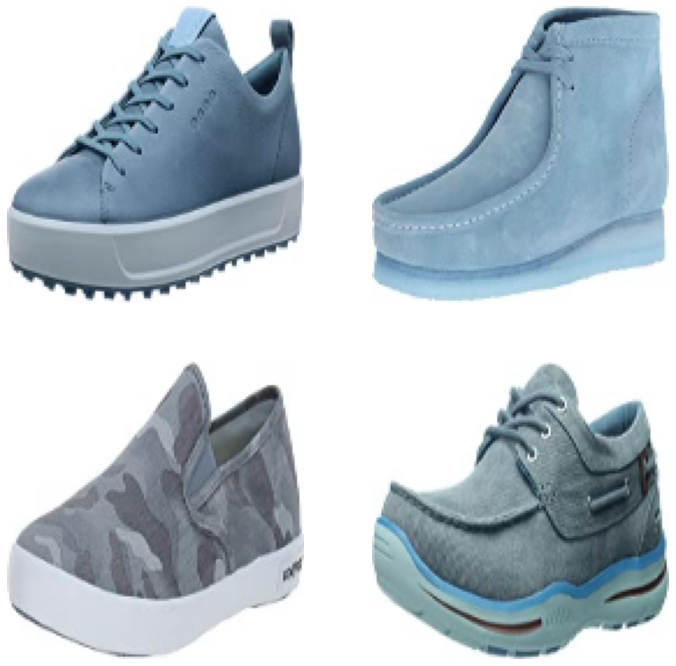

In [43]:
fig=plt.figure(figsize=(12, 12))
for i in range(1, 5):
    fig.add_subplot(2, 2, i)
    plt.imshow(X_train[indices2[0,i-1]])
    plt.axis('off') 
plt.show()

Very similar shape sizes were returned and it can been seen that the general light gray bluish color tone was in the closest matches although the shoe types may not be similar. 

**Test #3 Image Generation**

In [48]:
# Repeat KNN prediction on random image
random_index3 = np.random.randint(0,len(X_test)) 
single_image3 = X_test[random_index3]
single_image3_features = rec_model.predict(np.expand_dims(single_image3,axis=0))
indices3 = nbrs.kneighbors(single_image3_features,4,return_distance=False)

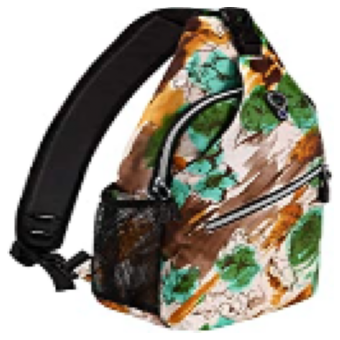

In [49]:
plt.figure(figsize=(6, 6))
plt.imshow(single_image3)
plt.axis('off') 
plt.show()

**Test #3 Results - Closest Matching Images**



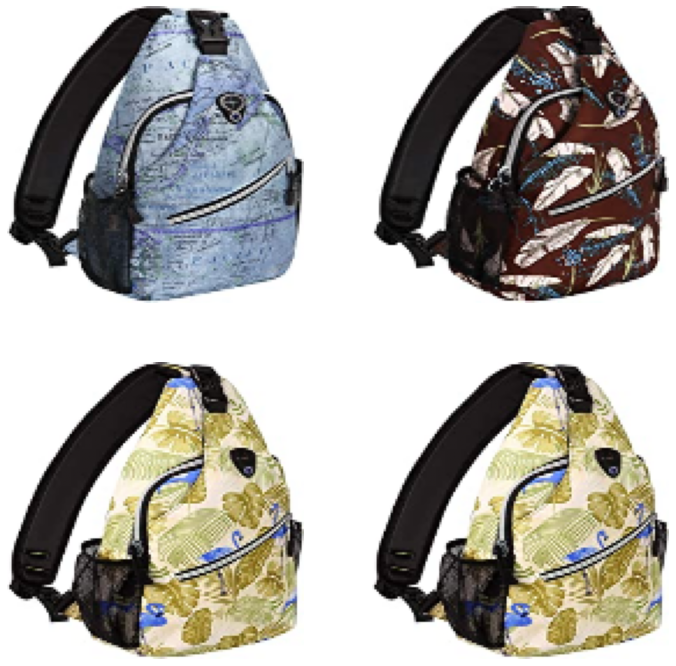

In [50]:
fig=plt.figure(figsize=(12, 12))
for i in range(1, 5):
    fig.add_subplot(2, 2, i)
    plt.imshow(X_train[indices3[0,i-1]])
    plt.axis('off') 
plt.show()

For this round of matching, the exact same brand of bag was returned with the same shape and general pattern recognition. Even though the surface designs are non-homogenous, the main features were compatibly matched.

**Conclusion**

The KNN based recommendation model manages to get the product type classification correctly. It also performs relatively well with respect to dimensional,color and design features, being able to capture these elements with a good degree of likeness. For more intricate patterns and instances with the presence of a variety of different colors, the model performs moderately but it can be also due to the inherent fact that the dataset itself contains limited alternative matches given that most products listed are expected to be unique and repeat listings are often not frequent. With just 5,000 images per category, the performance of these predictions are bound by the volume and richness of the source data.